In [4]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [5]:
DATA_PATH = ".\\Прогнозування розривів.csv"
dataset = pd.read_csv(DATA_PATH, sep=';', encoding = 'cp1251')

In [173]:
#The structure of dataset
print("Договори почали діяти з {} по {}".format(min(dataset['Year of beginning']), max(dataset['Year of beginning'])))
sum_for_normalization = dataset['Внесок останній сплачений'].sum()
print(sum_for_normalization)
#By program
print("Кількість програм ", dataset['Program(Code)'].nunique())
df_program = dataset.loc[:, ['Program(Code)', 'Внесок останній сплачений']]
df_program = df_program.groupby('Program(Code)').sum()
print(df_program.axes[0].astype('str').tolist())
#print(df_program['Внесок останній сплачений'].tolist())

#By chanel
print("Кількість каналів ", dataset['Chanel'].nunique())
df_chanel = dataset.loc[:, ['Chanel', 'Внесок останній сплачений']]
# Change names of chanel to numbers
numbers = list(range(0, len(df_chanel['Chanel'].unique())))
zipped = zip(df_chanel['Chanel'].unique(), numbers)
dic_for_chanels = dict(zipped)
df_chanel['Chanel'].replace(dic_for_chanels, inplace=True)
df_chanel = df_chanel.groupby('Chanel').sum()
print(df_chanel)



Договори почали діяти з 2005 по 2022
667443934.3900001
Кількість програм  66
['3', '4', '7', '8', '10', '11', '13', '14', '15', '16', '17', '18', '19', '21', '25', '26', '27', '28', '30', '31', '32', '36', '41', '42', '43', '51', '52', '53', '54', '55', '56', '57', '59', '60', '61', '62', '63', '64', '65', '66', '67', '69', '71', '72', '73', '74', '75', '77', '78', '79', '80', '81', '82', '83', '84', '85', '87', '88', '89', '90', '91', '93', '94', '97', '98', '99']
Кількість каналів  13
        Внесок останній сплачений
Chanel                           
0                    1.595947e+08
1                    1.705914e+08
2                    6.762915e+07
3                    1.081379e+07
4                    3.863025e+07
5                    3.185838e+06
6                    8.613432e+07
7                    9.879452e+07
8                    1.653711e+07
9                    2.509290e+06
10                   5.554853e+04
11                   1.152101e+07
12                   1.447014e+0

<BarContainer object of 66 artists>

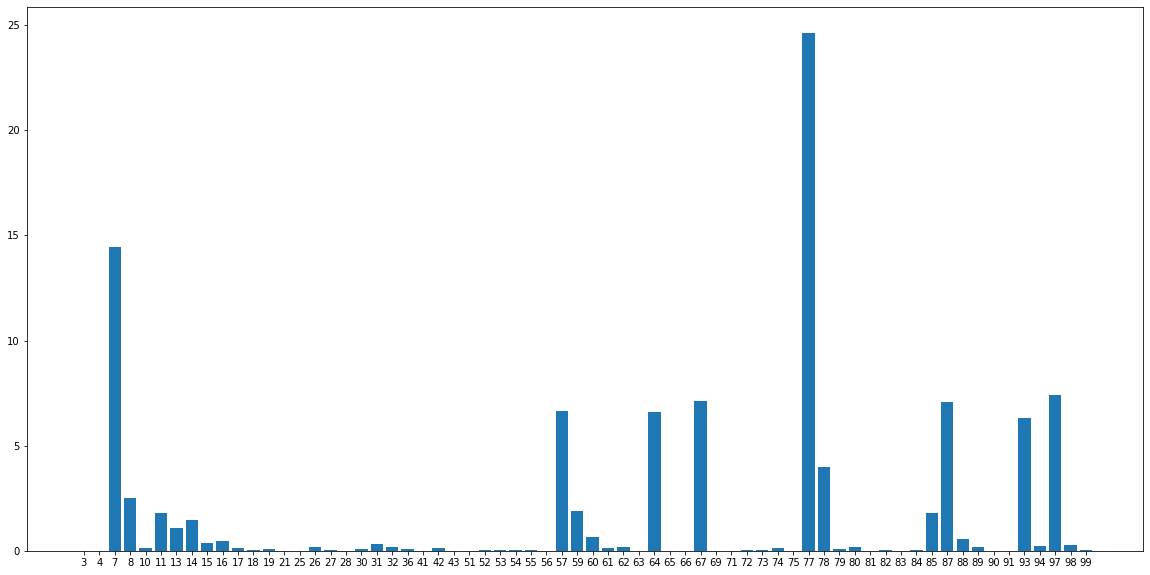

In [140]:
#Plot for programs
plt.subplots(figsize=(20,10))
plt.bar(df_program.axes[0].astype('str').tolist(), 
        df_program['Внесок останній сплачений'].tolist()/sum_for_normalization*100)


<BarContainer object of 13 artists>

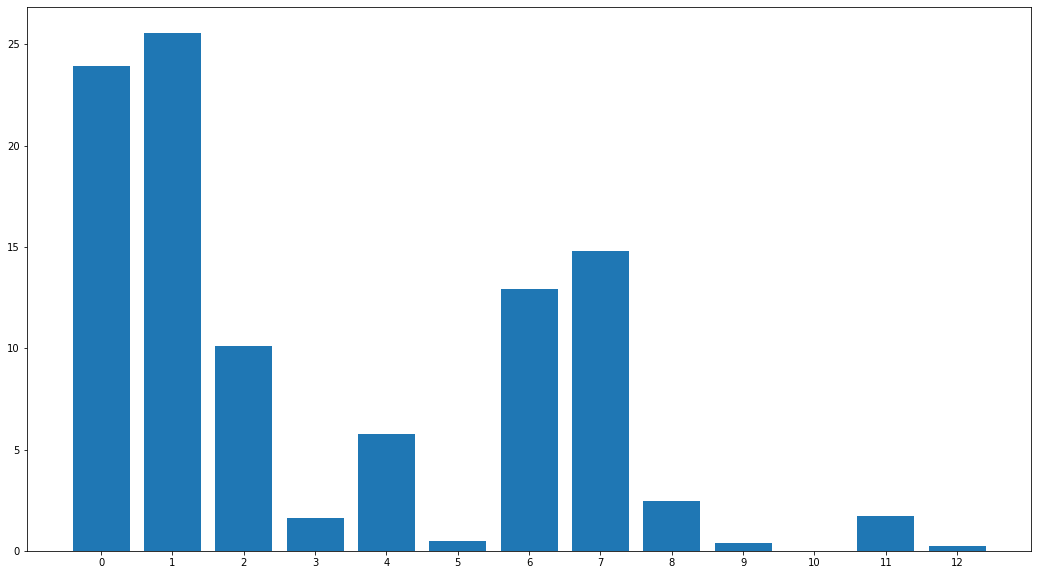

In [141]:
#Plot for chanels
plt.subplots(figsize=(18,10))
plt.bar(df_chanel.axes[0].astype('str').tolist(), 
        df_chanel['Внесок останній сплачений'].tolist()/sum_for_normalization*100)

<BarContainer object of 3 artists>

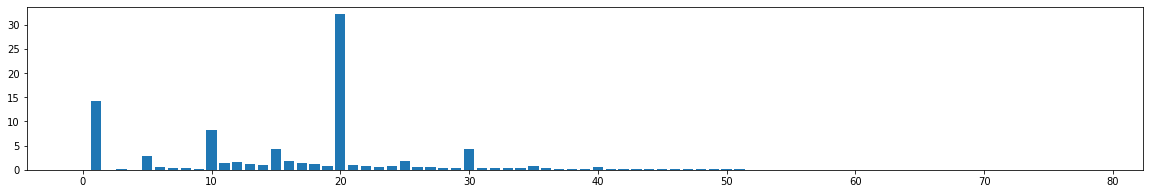

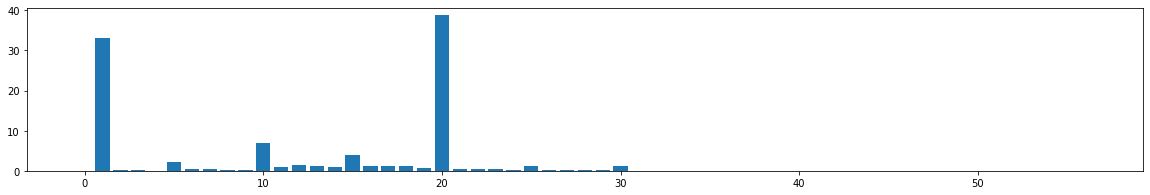

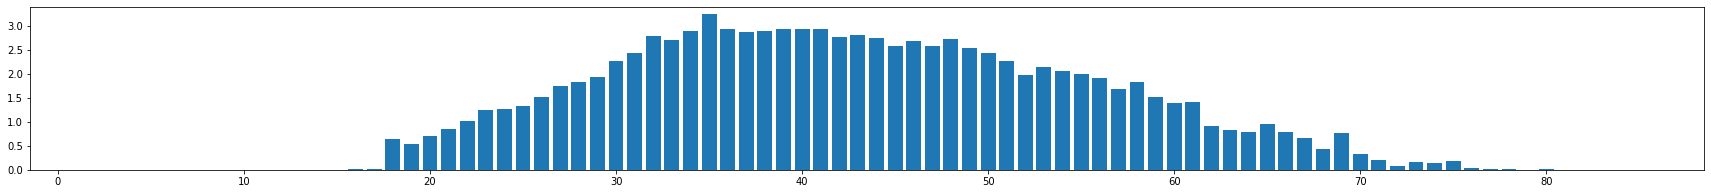

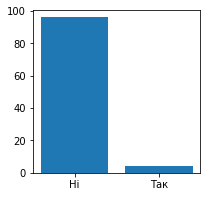

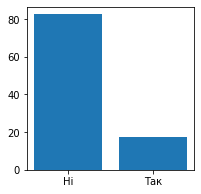

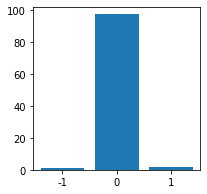

In [158]:
#Plots for others
df_matur = dataset.loc[:, ['Maturity', 'Внесок останній сплачений']]
df_matur = df_matur.groupby('Maturity').sum()
plt.subplots(figsize=(20,3))
plt.bar(df_matur.axes[0].astype('int').tolist(), 
        df_matur['Внесок останній сплачений'].tolist()/sum_for_normalization*100)

df_len = dataset.loc[:, ['Duration of payment', 'Внесок останній сплачений']]
df_len = df_len.groupby('Duration of payment').sum()
plt.subplots(figsize=(20,3))
plt.bar(df_len.axes[0].astype('int').tolist(), 
        df_len['Внесок останній сплачений'].tolist()/sum_for_normalization*100)        

df_age = dataset.loc[:, ['Вік Стр-ка на початок', 'Внесок останній сплачений']]
df_age = df_age.groupby('Вік Стр-ка на початок').sum()
plt.subplots(figsize=(30,3))
plt.bar(df_age.axes[0].astype('int').tolist(), 
        df_age['Внесок останній сплачений'].tolist()/sum_for_normalization*100)   

df_ande = dataset.loc[:, ['Наявні надбавки', 'Внесок останній сплачений']]
df_ande = df_ande.groupby('Наявні надбавки').sum()
plt.subplots(figsize=(3,3))
plt.bar(df_ande.axes[0].astype('str').tolist(), 
        df_ande['Внесок останній сплачений'].tolist()/sum_for_normalization*100)

df_lapse = dataset.loc[:, ['Редукувався раніше', 'Внесок останній сплачений']]
df_lapse = df_lapse.groupby('Редукувався раніше').sum()
plt.subplots(figsize=(3,3))
plt.bar(df_lapse.axes[0].astype('str').tolist(), 
        df_lapse['Внесок останній сплачений'].tolist()/sum_for_normalization*100)   

df_change = dataset.loc[:, ['Актуарно змінений.1', 'Внесок останній сплачений']]
df_change = df_change.groupby('Актуарно змінений.1').sum()
plt.subplots(figsize=(3,3))
plt.bar(df_change.axes[0].astype('str').tolist(), 
        df_change['Внесок останній сплачений'].tolist()/sum_for_normalization*100)  



In [1]:
def split_data(dataset, ratio):
    '''
    Splits dataset into train/test parts using given ratio;
    Parameters:
        data    -   array of features;
        labels  -   array of corresponding labels;
        ratio   -   train/test size ratio;
    Returns:
        train_data      -   array of training features;   
        test_data       -   array of testing features; 
    '''    

    lapsed_data = dataset[dataset['Lap_reason'] > 0] # with lapses
    nonlapsed_data = dataset[dataset['Lap_reason'] == 0] # withoup lapses

    # We shuffle arrays to get random samples later
    random_indecies_lapped = lapsed_data.sample(frac = 1)
    random_indecies_nonlapped = nonlapsed_data.sample(frac = 1)

    n_lapsed_train = int(lapsed_data.shape[0] * ratio)
    n_nonlapsed_train = int(nonlapsed_data.shape[0] * ratio)

    # Training data are all indecies in 'ratio' part of shuffled indecies
    train_data = pd.concat([random_indecies_lapped[:n_lapsed_train], 
                                random_indecies_nonlapped[:n_nonlapsed_train]], axis = 0)
    # Testing data are all indecies that remain
    test_data = pd.concat([random_indecies_lapped[n_lapsed_train:], 
                                random_indecies_nonlapped[n_nonlapsed_train:]], axis = 0)

    return train_data.drop('Lap_reason', axis = 1), train_data[['Lap_reason']],  test_data.drop('Lap_reason', axis = 1), test_data[['Lap_reason']]

In [4]:
def get_metrics(labels, predictions):
    '''
    Computes metrics;
    Parameters:
        labels    -   array of labels;
        predictions  -   array of predictions;
    Returns:
        FAR -   False Acceptance Rate;
        FRR -   False Rejection Rate;
    '''  
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    FRR = fp / (fp + tn) * 100
    FAR = fn / (tp + fn) * 100
    return FAR, FRR

Check data split

In [6]:
train_lapses = int(dataset[dataset.Lap_reason >= 3].shape[0]) / int(dataset.shape[0])
print(" % of lapsed insurance policies in dataset: ", train_lapses * 100)

train_data = split_data(dataset, ratio = 0.7)[0]
train_labels = split_data(dataset, ratio = 0.7)[1]
train_lapses = len(train_labels[train_labels['Lap_reason'] >= 3]) / int(train_data.shape[0])
print(" % of lapsed insurance policies in train dataset: ", train_lapses * 100)

test_data = split_data(dataset, ratio = 0.7)[2]
test_labels = split_data(dataset, ratio = 0.7)[3]
test_lapses = len(test_labels[test_labels['Lap_reason'] >= 3]) / int(test_data.shape[0])
print(" % of lapsed insurance policies in test dataset: ", test_lapses * 100)


 % of lapsed insurance policies in dataset:  3.2642991529952634
 % of lapsed insurance policies in train dataset:  3.264140175159188
 % of lapsed insurance policies in test dataset:  3.264670099247365


In [33]:
train_data.columns

Index(['INITIALID', 'Program(Code)', 'Chanel', 'Beginning',
       'Year of beginning', 'Quarter of beggining', 'Maturity',
       'Duration of payment', 'Payment Frequency', 'Вік Стр-ка на початок',
       'Вік Стр-ка на момент змін', 'Редукувався раніше', 'Стать Стр-ка',
       'Наявні надбавки', 'Внесок', 'Внесок останній сплачений', 'СС',
       'Валюта', 'С=ЗО', 'Регіон', 'Місто/Село', 'Населений пункт', 'Є діти',
       'Сімейний стан', 'Професія', 'є ще накоп. договір',
       'є ризиковий договір', 'є дитячий договір', 'є НУВ', 'клієнт=агент',
       'спосіб оплати', 'Індексований', 'Актуарно змінений',
       'Актуарно змінений.1', 'Розрив.причина', 'Quarters to lap',
       'Quarters to the last lap'],
      dtype='object')

C:\Users\skvor\AppData\Local\Temp\ipykernel_12404\2512693781.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(cor, mask = np.zeros_like(cor, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap=True),


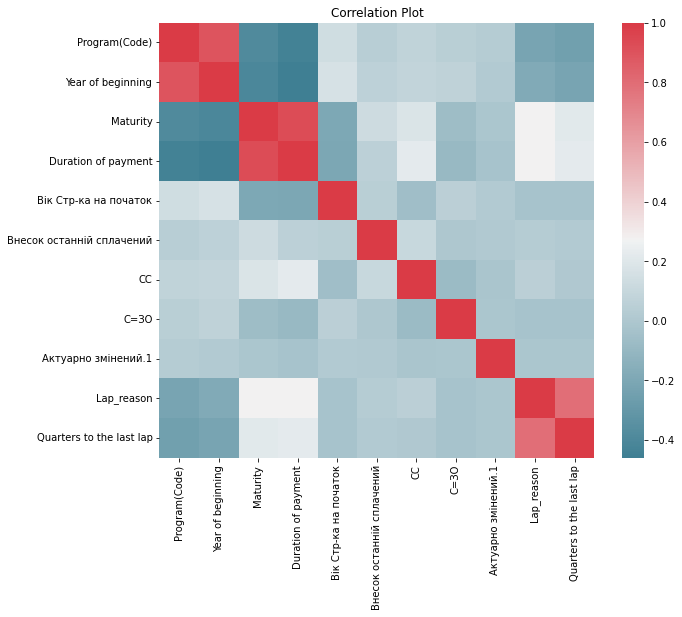

In [97]:

#Will check correlation between different features
features = ['Program(Code)', 'Chanel', 'Year of beginning', 'Maturity',
       'Duration of payment', 'Payment Frequency', 'Вік Стр-ка на початок',
       'Редукувався раніше', 'Наявні надбавки', 'Внесок останній сплачений', 'СС',
       'Валюта', 'С=ЗО', 'Місто/Село', 'спосіб оплати', 'Індексований', 'Актуарно змінений.1', 
       'Lap_reason', 'Quarters to the last lap']
corr_df = dataset[features]
cor = corr_df.corr(method = 'pearson')

fig, ax = plt.subplots(figsize=(10, 8))
plt.title("Correlation Plot")
sns.heatmap(cor, mask = np.zeros_like(cor, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Start preparing data to make it suitable for modelling

In [5]:
# Change names of chanel to numbers
dataset_for_modelling = dataset
numbers = list(range(0, len(dataset_for_modelling['Chanel'].unique())))
zipped = zip(dataset_for_modelling['Chanel'].unique(), numbers)
dic_for_chanels = dict(zipped)
dataset_for_modelling['Chanel'].replace(dic_for_chanels, inplace=True)

#Change payment freauency to numbers
dic_for_frequency = {
    'одноразово': 0,
    "щорічно": 1,
    "раз в півроку": 2,
    "щоквартально": 4,
    "щомісяця": 12
}
dataset_for_modelling['Payment Frequency'].replace(dic_for_frequency, inplace=True)

#If there were lapses earlier
dic_for_lapse = {
    'Ні': 0,
    "Так": 1
}
dataset_for_modelling['Редукувався раніше'].replace(dic_for_lapse, inplace=True)

#Change underwriters
dic_for_under = {
    'Ні': 0,
    "Так": 1
}
dataset_for_modelling['Наявні надбавки'].replace(dic_for_under, inplace=True)

#Change sex
dic_for_sex = {
    'F': 0,
    "M": 1
}
dataset_for_modelling['Стать Стр-ка'].replace(dic_for_sex, inplace=True)

#Change currency
numbers_cur = list(range(0, len(dataset_for_modelling['Валюта'].unique())))
zipped_cur = zip(dataset_for_modelling['Валюта'].unique(), numbers)
dic_for_currency = dict(zipped_cur)
dataset_for_modelling['Валюта'].replace(dic_for_currency, inplace=True)

#NUV
dic_for_NUV = {
    'Ні': 0,
    "Так": 1
}
dataset_for_modelling['є НУВ'].replace(dic_for_NUV, inplace=True)

#Children policy
dic_for_child = {
    'Ні': 0,
    "Так": 1
}
dataset_for_modelling['є дитячий договір'].replace(dic_for_child, inplace=True)

#Indexation
dic_for_child = {
    'Ні': 0,
    "Так": 1
}
dataset_for_modelling['Індексований'].replace(dic_for_child, inplace=True)

#Payment Type
dic_for_paytype = {
    'Каса': 0,
    "Сайт": 1
}
dataset_for_modelling['спосіб оплати'].replace(dic_for_paytype, inplace=True)


In [37]:

dataset_for_modelling['Валюта'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [6]:
dic_for_lapses = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1
}
dataset_for_modelling['Lap_reason'].replace(dic_for_lapses, inplace=True)
#dataset_lapses = dataset.loc[:, ['Lap_reason', 'Maturity']]
#dataset_lapses['Lap_reason'].replace(dic_for_lapses, inplace=True)
#csq = chi2_contingency(pd.crosstab(dataset_lapses['Lap_reason'], dataset_lapses['Maturity']))
#print(dataset_lapses['Lap_reason'].unique())
#print("P-value: ",csq[1])

In [13]:
def evaluate(classifierType, hyperparameters, dataset):

    '''
    Splits dataset into train/test parts using given ratio;
    Parameters:
        classifierType      -   type of ML algorithm to use;
        hyperparameters     -   dictionary of model's parameters;
        dataset             -   DataFrame of dataset
    Returns:
        trainFAR    -   False Acceptance Rate for train dataset;
        trainFRR    -   False Rejection Rate for train dataset;
        testFAR     -   False Acceptance Rate for test dataset;
        testFRR     -   False Rejection Rate for test dataset;
    '''    

    model = GridSearchCV(classifierType(), hyperparameters, n_jobs = -1, refit = 'precision_score')

    # Split data
    train_data, train_labels, test_data, test_labels = split_data(dataset, ratio=0.7) 

    # Fit your model
    # add your code here
    fitted_model = model.fit(train_data, train_labels)
    # Make predictions for training dataset
    # add your code here
    predict_train = fitted_model.predict(train_data)

    # Compute train FAR/FRR
    # add your code here
    trainFAR, trainFRR = get_metrics(train_labels, predict_train)

    # Make predictions for testing dataset
    # add your code here
    predictions_test = fitted_model.predict(test_data)  
    # Compute test FAR/FRR
    # add your code here
    testFAR, testFRR = get_metrics(test_labels, predictions_test)
    print('\tThe best parametrs are', fitted_model.best_params_)
    return trainFAR, trainFRR, testFAR, testFRR

In [7]:
classifierType = sklearn.ensemble.RandomForestClassifier
hyperparameters = {'criterion' : ['gini'],
                'max_depth' : [None]}

In [35]:
features_1 = ['Program(Code)', 'Chanel', 'Maturity',
       'Duration of payment', 'Payment Frequency', 'Вік Стр-ка на початок',
       'Редукувався раніше', 'Внесок останній сплачений', 'СС',
       'Валюта', 'С=ЗО', 'є НУВ', 'спосіб оплати', 'Актуарно змінений.1', 
       'Lap_reason']
dataset_formodel_1 = dataset_for_modelling.loc[:, features_1]
#Delete NaN
dataset_without_nans = dataset_formodel_1.dropna()

In [85]:
# Make our dataset smaller
#dataset_without_nans = dataset_without_nans.sample(frac = 0.7)

#Change string values to Numeric Labels
#features_string = ['Chanel',  'Payment Frequency', 'Редукувався раніше', 'Наявні надбавки', 
#       'Валюта', 'Регіон', 'спосіб оплати', 'Індексований']
#dataset_without_nans[features_string] = dataset_without_nans[features_string].apply(LabelEncoder().fit_transform)
#dataset_without_nans

In [148]:
#Let's model
model = GridSearchCV(classifierType(), hyperparameters, n_jobs = -1, refit = 'precision_score')

# Split data
train_data, train_labels, test_data, test_labels = split_data(dataset_without_nans, ratio=0.7) 
train_labels = train_labels['Lap_reason'].tolist()
test_labels = test_labels['Lap_reason'].tolist()

# Fit model
fitted_model = model.fit(train_data, train_labels)
# Make predictions for training dataset
predict_train = fitted_model.predict(train_data)

print(type(predict_train))

# Compute train FAR/FRR
trainFAR, trainFRR = get_metrics(train_labels, predict_train)
# Make predictions for testing dataset
predictions_test = fitted_model.predict(test_data)  
# Compute test FAR/FRR
testFAR, testFRR = get_metrics(test_labels, predictions_test)
print('\tThe best parametrs are', fitted_model.best_params_)



In [107]:
#trainFAR, trainFRR, testFAR, testFRR = evaluate(classifierType, hyperparameters, dataset_without_nans)
print('Train:')
print('\tFAR:', trainFAR)
print('\tFRR:', trainFRR)

print('Test:')
print('\tFAR:', testFAR)
print('\tFRR:', testFRR)

Train:
	FAR: 1.5176183277125248
	FRR: 0.024782786168289696
Test:
	FAR: 13.798259923871669
	FRR: 0.41491894343045005


In [41]:

# Split data
train_data, train_labels, test_data, test_labels = split_data(dataset_without_nans, ratio=0.5) 
train_labels = train_labels['Lap_reason'].tolist()
test_labels = test_labels['Lap_reason'].tolist()

# Fit model
model_RF = RandomForestClassifier()
fitted_model_RF = model_RF.fit(train_data, train_labels)
# Make predictions for training dataset
predict_train_RF = fitted_model_RF.predict(train_data)

# Compute train FAR/FRR
trainFAR, trainFRR = get_metrics(train_labels, predict_train_RF)
# Make predictions for testing dataset
predictions_test_RF = fitted_model_RF.predict(test_data)  
# Compute test FAR/FRR
testFAR, testFRR = get_metrics(test_labels, predictions_test_RF)
print('Train:')
print('\tFAR:', trainFAR)
print('\tFRR:', trainFRR)

print('Test:')
print('\tFAR:', testFAR)
print('\tFRR:', testFRR)

acc_rf_train = round(model_RF.score(train_data, train_labels)*100, 2)
print(round(acc_rf_train,2,), "%")
acc_rf_test = round(model_RF.score(test_data, test_labels)*100, 2)
print(round(acc_rf_test,2,), "%")


Train:
	FAR: 1.513540047451526
	FRR: 0.022440888659190906
Test:
	FAR: 14.272970561998216
	FRR: 0.4021912960631529
99.86 %
98.52 %


In [125]:
scores = cross_val_score(model_RF, train_data, train_labels, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.98551505 0.98452845 0.98623257 0.98555989 0.98677071 0.98443876
 0.98623195 0.98439322 0.98461745 0.98537985]
Mean: 0.9853667905398329
Standard Deviation: 0.0008125191614442138


In [27]:
dict_for_model = zip(fitted_model_RF.feature_names_in_, fitted_model_RF.feature_importances_)
importances = pd.DataFrame({'feature':fitted_model_RF.feature_names_in_,'importance':np.round(fitted_model_RF.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(fitted_model_RF.n_features_in_)

,importance
feature,
Payment Frequency,0.332
Редукувався раніше,0.210
Внесок останній сплачений,0.072
СС,0.068
є НУВ,0.061
Maturity,0.059
Program(Code),0.056
Duration of payment,0.052
Вік Стр-ка на початок,0.040


<AxesSubplot:xlabel='feature'>

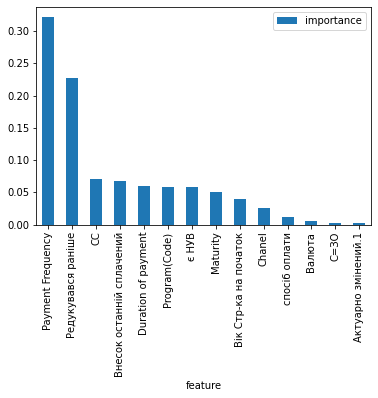

In [127]:
importances.plot.bar()

In [45]:
train_data  = train_data.drop('Актуарно змінений.1', axis=1)
test_data  = test_data.drop('Актуарно змінений.1', axis=1)

train_data  = train_data.drop('С=ЗО', axis=1)
test_data  = test_data.drop('С=ЗО', axis=1)

train_data  = train_data.drop( 'Валюта', axis=1)
test_data  = test_data.drop( 'Валюта', axis=1)

train_data  = train_data.drop( 'спосіб оплати', axis=1)
test_data  = test_data.drop( 'спосіб оплати', axis=1)


In [46]:

# Fit model
model_RF_2 = RandomForestClassifier()
fitted_model_RF_2 = model_RF_2.fit(train_data, train_labels)
# Make predictions for training dataset
predict_train_RF = fitted_model_RF_2.predict(train_data)

# Compute train FAR/FRR
trainFAR, trainFRR = get_metrics(train_labels, predict_train_RF)
# Make predictions for testing dataset
predictions_test_RF = fitted_model_RF_2.predict(test_data)  
# Compute test FAR/FRR
testFAR, testFRR = get_metrics(test_labels, predictions_test_RF)
print('Train:')
print('\tFAR:', trainFAR)
print('\tFRR:', trainFRR)

print('Test:')
print('\tFAR:', testFAR)
print('\tFRR:', testFRR)

acc_rf_train = round(model_RF_2.score(train_data, train_labels)*100, 2)
print(round(acc_rf_train,2,), "%")
acc_rf_test = round(model_RF_2.score(test_data, test_labels)*100, 2)
print(round(acc_rf_test,2,), "%")


Train:
	FAR: 1.6117156180970302
	FRR: 0.030601211807987593
Test:
	FAR: 14.57302732949477
	FRR: 0.3987886624247167
99.85 %
98.5 %


In [54]:
scores = cross_val_score(model_RF_2,  train_data, train_labels, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.9841788  0.98556002 0.98625063 0.98687845 0.98474385 0.9831115
 0.98455453 0.98461732 0.98480568 0.9856219 ]
Mean: 0.9850322677010446
Standard Deviation: 0.0010233122395721633


In [47]:
dict_for_model = zip(fitted_model_RF_2.feature_names_in_, fitted_model_RF.feature_importances_)
importances = pd.DataFrame({'feature':fitted_model_RF_2.feature_names_in_,'importance':np.round(fitted_model_RF_2.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(fitted_model_RF_2.n_features_in_)


,importance
feature,
Payment Frequency,0.332
Редукувався раніше,0.252
СС,0.069
Внесок останній сплачений,0.065
є НУВ,0.064
Program(Code),0.054
Maturity,0.054
Duration of payment,0.048
Вік Стр-ка на початок,0.037


<AxesSubplot:xlabel='feature'>

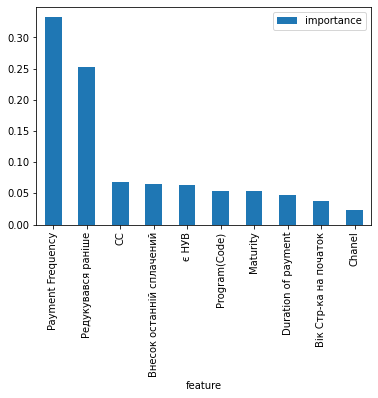

In [48]:
importances.plot.bar()

In [139]:
acc_rf = round(model_RF_2.score(train_data, train_labels)*100, 2)
print(round(acc_rf,2,), "%")

99.83 %


In [52]:
prob = fitted_model_RF_2.predict_proba(train_data)

In [53]:
r_a_score = roc_auc_score(train_labels, prob[:,1])
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.999954997383404


Modeling for prediction when is lapse going to happen

In [83]:
dataset_for_modelling.columns
dataset_for_modelling_time = dataset_for_modelling
dataset_for_modelling_time['Quarters to lapses'] = dataset_for_modelling_time['Quarters to the last lap'] * dataset_for_modelling['Lap_reason']

features_2 = ['Program(Code)', 'Chanel', 'Maturity',
       'Duration of payment', 'Payment Frequency', 'Вік Стр-ка на початок',
       'Редукувався раніше', 'Внесок останній сплачений', 'СС', 'є НУВ', 
       'Quarters to lapses']
dataset_formodel_time = dataset_for_modelling_time.loc[:, features_2]
#Delete NaN
dataset_without_nans_time = dataset_formodel_time.dropna()
print(dataset_without_nans_time[ 'Quarters to lapses'].unique())     

[ 0  8 12 16 10 14 20 18  4  9 13 40 30 24 11  2 15  1 22  6 36 21 17 26
 19 28 27 25 32 34 29 31 33 23 37 35 38 39 41 42 44  5 48 43 56 52 49 46
 45 47 51 54 58 55  3 50  7 59 62 60 53 64]


In [94]:

# Split data
train_data, train_labels, test_data, test_labels = split_data(dataset_without_nans_time, ratio=0.5) 
train_labels = train_labels['Quarters to lapses'].tolist()
test_labels = test_labels['Quarters to lapses'].tolist()

# Fit model
model_RF_time = RandomForestClassifier()
fitted_model_RF = model_RF_time.fit(train_data, train_labels)
# Make predictions for training dataset
predict_train_RF = fitted_model_RF.predict(train_data)

# Make predictions for testing dataset
predictions_test_RF = fitted_model_RF.predict(test_data)  

acc_rf_train = round(model_RF_time.score(train_data, train_labels)*100, 2)
print(round(acc_rf_train,2,), "%")
acc_rf_test = round(model_RF_time.score(test_data, test_labels)*100, 2)
print(round(acc_rf_test,2,), "%")

99.59 %
94.38 %


In [95]:
scores = cross_val_score(model_RF_time,  train_data, train_labels, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

c:\Users\skvor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Scores: [0.9443119  0.94318182 0.94506529 0.94450025 0.94293069 0.94424562
 0.94550135 0.94361776 0.94562692 0.94374333]
Mean: 0.9442724933135255
Standard Deviation: 0.000878974333738965


<AxesSubplot:xlabel='feature'>

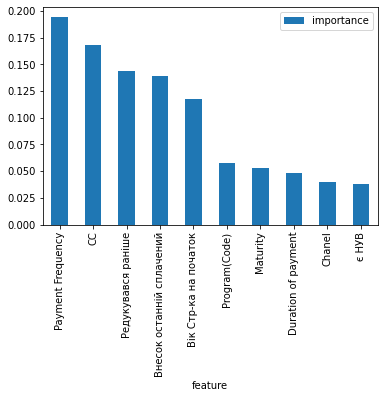

In [77]:
dict_for_model = zip(model_RF_time.feature_names_in_, fitted_model_RF.feature_importances_)
importances = pd.DataFrame({'feature':model_RF_time.feature_names_in_,'importance':np.round(model_RF_time.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(model_RF_time.n_features_in_)
importances.plot.bar()

In [85]:
prob = fitted_model_RF_2.predict_proba(train_data)

[[0.91 0.09]
 [0.   1.  ]
 [0.   1.  ]
 ...
 [1.   0.  ]
 [0.76 0.24]
 [1.   0.  ]]


In [96]:
classifierType = sklearn.ensemble.RandomForestClassifier
hyperparameters = {'criterion' : ['gini'],
                'max_depth' : [None]}

In [99]:
# Fit model
model_RF_time = RandomForestClassifier(n_estimators = 500, criterion = 'gini', max_features = 'log2', oob_score=True)
fitted_model_RF = model_RF_time.fit(train_data, train_labels)
# Make predictions for training dataset
predict_train_RF = fitted_model_RF.predict(train_data)

# Make predictions for testing dataset
predictions_test_RF = fitted_model_RF.predict(test_data)  

acc_rf_train = round(model_RF_time.score(train_data, train_labels)*100, 2)
print(round(acc_rf_train,2,), "%")
acc_rf_test = round(model_RF_time.score(test_data, test_labels)*100, 2)
print(round(acc_rf_test,2,), "%")

99.59 %
94.39 %


In [101]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(train_data, train_labels)

Y_pred = logreg.predict(test_data)

acc_log = round(logreg.score(train_data, train_labels) * 100, 2)
print(round(acc_log,2,), "%")
acc_log = round(logreg.score(test_data, test_labels) * 100, 2)
print(round(acc_log,2,), "%")

c:\Users\skvor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


92.29 %
92.29 %


In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(train_data, train_labels)

Y_pred = knn.predict(test_data)

acc_knn = round(knn.score(train_data, train_labels) * 100, 2)
print(round(acc_knn,2,), "%")
acc_knn = round(knn.score(test_data, test_labels) * 100, 2)
print(round(acc_knn,2,), "%")

93.35 %
91.67 %


In [103]:
# Gaussian Naive train_labels
gaussian = GaussianNB()
gaussian.fit(train_data, train_labels)

Y_pred = gaussian.predict(test_data)

acc_gaussian = round(gaussian.score(train_data, train_labels) * 100, 2)
print(round(acc_gaussian,2,), "%")
acc_gaussian = round(gaussian.score(test_data, test_labels) * 100, 2)
print(round(acc_gaussian,2,), "%")

73.69 %
73.54 %
